In [1]:
# Generales
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import pandas as pd
import numpy as np

# Sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer  # Stopwords

# Tensorflow y Keras
import tensorflow as tf
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
def get_dictionary(text, sw, N):
    vectorizer = CountVectorizer(stop_words=sw, max_features=N)
    vectorizer.fit_transform(text)
    dictionary = vectorizer.vocabulary_
    dictionary = {word: i + 2 for i, word in enumerate(vectorizer.get_feature_names_out())}
    dictionary['DESC'] = 0
    dictionary['PAD'] = 1
    return dictionary

In [3]:
def limpiar_texto(texto):
    # Eliminar URLs (http o https)
    texto = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", '', texto)
    # Eliminar menciones (por ejemplo, @usuario)
    texto = re.sub(r'\@w+', '', texto)
    # Eliminar emoticonos o símbolos como ;) o similares
    texto = re.sub(r'[^\w\s]', '', texto)  # Esto elimina todos los caracteres especiales, dejando solo letras y números
    # Eliminar espacios extra
    texto = texto.strip()
    return texto

In [4]:
texto = "Hola @usuario, visita http://example.com para más info! ;) #feliz #día"
print(limpiar_texto(texto))

Hola usuario visita  para más info  feliz día


In [76]:
def text_to_sequence(text, dictionary, stop_words, T):
    palabras = re.findall(r'\b\w+\b', text.lower())  # Tokenizar correctamente
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    secuencia = [dictionary.get(palabra, dictionary['DESC']) for palabra in palabras]
    secuencia = secuencia[:T]
    secuencia += [dictionary['PAD']] * (T - len(secuencia))
    return np.array(secuencia)

In [77]:
# Parámetros configurables
N = 20000  # Número de palabras del diccionario
T = 100    # Longitud prefijada de la reseña
EPOCHS = 20
NEURONAS = 128

# Usamos la lista de stopwords de sklearn
stop_words = list(ENGLISH_STOP_WORDS)

path = "/kaggle/input/tweetsdata/tuits_desastres.csv"

datos = pd.read_csv(path)

In [78]:
datos.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [79]:
datos.drop(["id", "keyword", "location"], axis=1, inplace=True)

In [80]:
datos.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [81]:
# Variable objetivo
y = datos['target']
num_clases = len(y.unique())

# Textos de reseñas
textos = datos['text'].apply(limpiar_texto)  # Limpia los textos antes de procesarlos
X = []
diccionario = get_dictionary(textos, stop_words, N)  # Crea el diccionario con textos limpios
for texto in textos:
    X.append(text_to_sequence(texto, diccionario, stop_words, T))  # Convierte los textos a secuencias
# X contendrá las reseñas codificadas y rellenas con la misma longitud
X = np.array(X)

In [82]:
datos.head(50)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


In [163]:
first_key, first_value = next(iter(diccionario.items()))
print(first_key, first_value)

00 2


In [165]:
X.shape

(20491, 100)

In [166]:
y.shape[1]

5

In [167]:
X.shape[1]

100

In [168]:
X = pad_sequences(textos.apply(lambda t: text_to_sequence(t, diccionario, stop_words, T)), 
                  maxlen=T, padding='post')  # T debe ser la longitud deseada (ej: 100)
y = datos['target']

In [169]:
print(X.shape[0])
print(y.shape)

20491
(20491, 5)


In [170]:
N = 5  # Tamaño del vocabulario
D = 5  # Dimensión del embedding
embedding_layer = Embedding(input_dim=N, output_dim=D)
entrada = np.array([[4, 3, 1, 1, 3]])
embeddings = embedding_layer(entrada)
print('Representación de {}'.format(str(entrada)))
print(embeddings.numpy())

Representación de [[4 3 1 1 3]]
[[[ 0.00084611 -0.0033526   0.00414083  0.01472929 -0.01211451]
  [ 0.0219128  -0.01863509  0.01346631  0.0325528   0.01370335]
  [ 0.01815731 -0.02452459  0.04275959  0.03269092  0.01216435]
  [ 0.01815731 -0.02452459  0.04275959  0.03269092  0.01216435]
  [ 0.0219128  -0.01863509  0.01346631  0.0325528   0.01370335]]]


In [172]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS, return_sequences=True)),
    Bidirectional(LSTM(units=NEURONAS)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(units=num_clases, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)             │ (None, 100, 5)              │              35 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_56 (Bidirectional)     │ (None, 100, 256)            │         137,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_57 (Bidirectional)     │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 572,968 (2.19 MB)

 Trainable params: 572,968 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [173]:
history = model.fit(X, y, validation_split=0.2, epochs=EPOCHS, batch_size=32, verbose=1)

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.4188 - loss: 1.4154 - val_accuracy: 0.4899 - val_loss: 1.3022
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4301 - loss: 1.3685 - val_accuracy: 0.4899 - val_loss: 1.2852
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4308 - loss: 1.3616 - val_accuracy: 0.4909 - val_loss: 1.2884
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4324 - loss: 1.3581 - val_accuracy: 0.4862 - val_loss: 1.2908
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4306 - loss: 1.3596 - val_accuracy: 0.4935 - val_loss: 1.2988
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4336 - loss: 1.3597 - val_accuracy: 0.4896 - val_loss: 1.2794
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4278 - loss: 1.3591 - val_accuracy: 0.4911 - val_loss: 1.2767
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4350 - loss: 1.3543 - val_accu

In [174]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

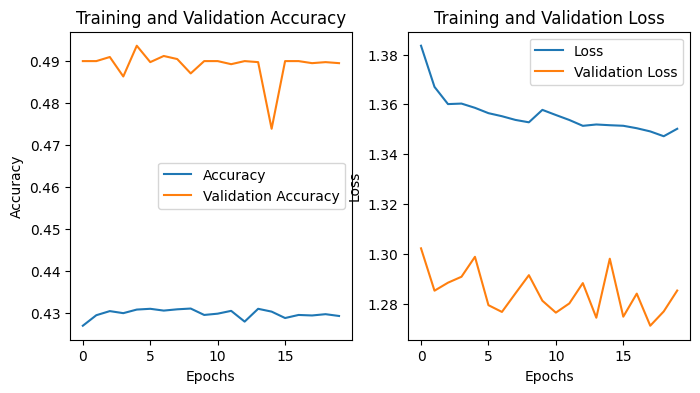

In [175]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()